##  A case study with cognitive levels 

- Distribution of tasks over 6 levels (distribution of all properties preferably)
- Categorise tasks and see how tasks over different categories distributed over levels (some are concentrated, some are all over the place, e.g. job hunting.)
- How are other attributes distributed over 6 levels (further cf. D.K)
- Correlation between log stats and task attributes (may not be necessary)

## Setup


In [109]:
%matplotlib inline
import pymongo
from pymongo import MongoClient
import numpy as np
import itertools
import urllib
import sys
sys.path.append('../variables/')
import UserActivity
import matplotlib.pylab as pylab
import matplotlib
from bson.objectid import ObjectId
from scipy.stats import gaussian_kde, ks_2samp

outputdir = 'plots/'

font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2

# DB connections
client = MongoClient()
db = client.db_tasklog_clean
# Collections
User = db.user
Log = db.log_chrome
Labelled = db.data_labeled
UserTasks = db.user_tasks

# Tasks to be excluded
to_exclude = ['000', '001', '002', '003', '004']
# Pre-defined labels - excluding "not sure (001)"
pre_tasks = ['001', '002', '003', '004']
# new query 
query_events = ['tab-search-new', 'tab-search-verticle'] 
# Get user task activities
# Set dummy parametersb
t_thresh = -1 # Look at first X minutes, not used
session_thresh = 30 # in minutes, threshold to consider users have left without closing the tab, not used
to_include = [] # Not used for this computation 

# Task properties names
TP = {
      'task_stage': 'STG',
      'task_collaboration': 'COL',
      'task_difficulty_subjective': 'DIF',
      'task_sailence_subjective': 'IMP',
      'task_frequency': 'FQ',
      'task_satisfaction': 'SAT',
      'task_knowledge_topic': 'KT',
      'task_complexity_objective': 'CL',
      'task_knowledge_procedure': 'KP',
      'task_complexity_subjective': 'COM',
      'task_length': 'TL',
      'task_urgency_subjective': 'UR'
 }
TP_exclude = ['task_goals_quantity']

CL_levels = {
    'remember': 1,
    'understadn': 2,
    'apply': 3,
    'analyse': 4,
    'evaluate': 5,
    'create': 6
}
CL_labels = {
    1: 'Rem',
    2: 'Und',
    3: 'App',
    4: 'Ana',
    5: 'Eva',
    6: 'Cre'
}

## Functions of getting labelled tasks

In [110]:
def all_registered_tasks():
    all_tasks = list(UserTasks.find({'task_level': 0}))
    return all_tasks

def task_names():
    all_tasks = list(UserTasks.find({'task_level': 0}))
    T = []
    for t in all_tasks:
        T.append((str(t['_id']), t['task']))
    return dict(T)

def get_postQ():
    Task_Q = []
    for u in User.find({}):
        Q = u['postQ']['questionnaire']
        for t in Q:
            questions = dict([(TP[q], Q[t][q]) for q in Q[t] if not q in TP_exclude])
            Task_Q.append((t, questions))
    return Task_Q


In [5]:
# All events
def event_stream(data):
    events = []
    # data consists of tab-groups
    for s in data:
        tab_group = s['tab_group']
        tabid = s['tabid']
        # tab groups consist of url groups
        for ug in tab_group:
            # a group of events sharing the same url
            url_group = ug['url_group']
            for e in url_group:
                events.append(e)
    events.sort(key=lambda x: x['timestamp_bson'])
    return events

# Get logical sessions
# Criteria for logical session:
# 1. consecutive events belong to the same task
# 2. a pause longer than 90 mins makes a session break (user may have left)
# Data format: stream of events
# Data should have already been filtered to only include event where the user is "on"
# A logical session should last more than 0 seconds
def logical_session(data):
    L = []
    s = []
    prev = -1
    for event, on in data:
        if prev == -1:
            prev = event
            s.append(event)
            continue
        gap = (event['timestamp_bson'] - prev['timestamp_bson']).total_seconds()/60
        # Keep adding to the logical session if conditions are satisfied
        if prev['taskid'] == event['taskid'] and gap < 90:
            s.append(event)
        # Otherwise, start a new session
        else:
            slength = (s[-1]['timestamp_bson'] - s[0]['timestamp_bson']).total_seconds()
            # Filter out sessions that last 0 seconds
            if not s == [] and slength > 0:
                L.append(s)
            s = []
            s.append(event)
        prev = event
    # Add the last session
    slength = (s[-1]['timestamp_bson'] - s[0]['timestamp_bson']).total_seconds()
    if not s == [] and slength > 0:
        L.append(s)
    return L
    

# Gether user activity data for analysis
UA = []
users = list(User.find({}))
for u in users:
    userid = u['userid']
    data = list(Labelled.find({'userid': u['userid']}))[0]['data']
    events = event_stream(data)
    ua = UserActivity.UserActivity(data, to_include, t_thresh, session_thresh)
    a_path, a_stream = ua.get_user_path()
    
    # filter out events where user was not on the tab
    user_stream = list(itertools.ifilter(lambda x: x[1] == True, a_stream))
    UA.append((userid, user_stream))

## Distributions of task properties
* To show there are enough data for each level for each property

{1: [92, 31, 38, 3, 52, 20, 48, 8, 14, 0, 14, 42], 2: [8, 23, 13, 8, 17, 10, 20, 12, 24, 8, 12, 26], 3: [12, 28, 28, 27, 33, 25, 27, 32, 23, 32, 37, 27], 4: [2, 17, 18, 31, 12, 18, 27, 36, 28, 32, 31, 17], 5: [21, 36, 25, 66, 21, 62, 13, 47, 46, 63, 41, 23], 6: [0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Total number of postQ tasks: 135


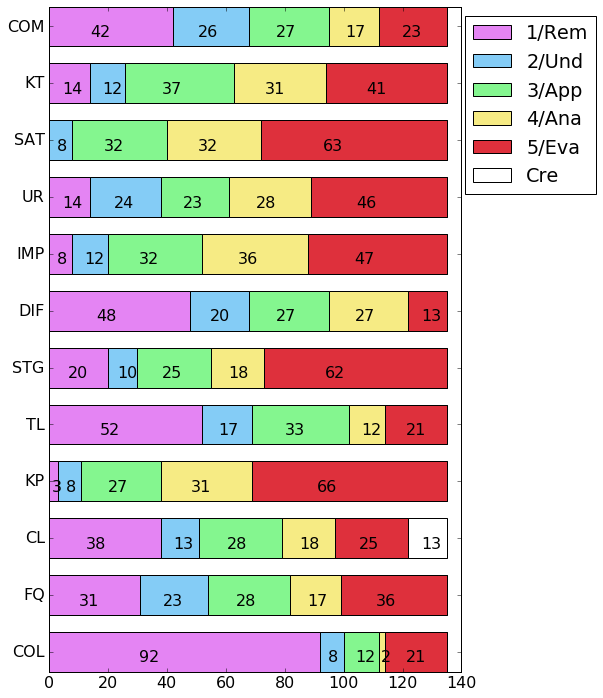

In [111]:
postQ = get_postQ()
Q = TP.values()




stacks = dict([(i, []) for i in range(1, 7)])
for q in Q:
    # Count number of each value for each question
    answers = [questions[q] if not questions[q] in CL_levels else CL_levels[questions[q]] 
               for t, questions in postQ]
    for i in range(1, 7):
        stacks[i].append(answers.count(i))
print stacks

# Stack values from 1 - 5 (1 - 6 for CL)
fig, ax1 = pylab.subplots(figsize=(7, 10))
# Y axis positions
pos = np.arange(len(Q)) + 0.5  
bheight = 0.7

colors = ['#E484F3', '#84CCF6', '#84F68F', '#F6EB84', '#DE303C', 'w']
left_x = np.array([0 for i in range(len(Q))])
for i in range(1, 7):
    legend = '%s/%s'%(i, CL_labels[i])
    if i == 6:
        legend = CL_labels[i]
    barlength = np.array(stacks[i])
    rects = ax1.barh(pos, barlength, align="center", left=left_x, height=bheight, 
                     color = colors[i-1], tick_label=Q, label=legend)
    left_x += barlength
    p = 0
    for rect in rects:
        x = left_x[p] - barlength[p]/1.5
        y = pos[p] - (bheight/4.)
        label = barlength[p]
        if barlength[p] == 0:
            p += 1
            continue
        ax1.text(x, y, label)
        p += 1

ax1.grid(False)
lgd = ax1.legend(bbox_to_anchor=(1.35, 1.0))

pylab.tight_layout()
figure = '%s/properties_dist.eps'%outputdir
pylab.savefig(figure, bbox_extra_artists=(lgd,), bbox_inches='tight')
print "Total number of postQ tasks:", len(postQ)

## Confirm if level of other attributes differs w.r.t cognitive levels

In [113]:
postQ = get_postQ()
Q = TP.values()

# group tasks by CL levels
postQ.sort(key=lambda x: x[1]['CL'])
groups = []
for k, g in itertools.groupby(postQ, lambda x: x[1]['CL']):
    groups.append((k, list(g)))
    


analyse 18
apply 28
create 13
evaluate 25
remember 38
understadn 13


## Task content category distributed over the 6 levels